### Data Pre-Processing

In [ ]:
!nvidia-smi

Fri Mar 18 11:12:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive._mount('/content/drive', force_remount= True)

In [ ]:
# !sudo apt-get install -y python-dev pkg-config
# !sudo apt-get install -y \
#     libavformat-dev libavcodec-dev libavdevice-dev \
#     libavutil-dev libswscale-dev libswresample-dev libavfilter-dev
# !pip install av

# import av
# import glob
# import os
# import time
# import tqdm
# import datetime
# import argparse

In [ ]:
import os
os.listdir("/content/drive/Shareddrives/Manthan Data/Videos")

['Snatch',
 'Accident',
 'Knife',
 'Arson',
 'Explosion',
 'Burglary',
 'Fighting',
 'Assault',
 'Normal',
 'Abuse']

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow


def dataprep(path, seq_len, res):
 for c in os.listdir(path):
  if not os.path.exists(os.path.join(res,c)):
    os.makedirs(os.path.join(res,c))
  for v in os.listdir(os.path.join(path, c)):
    
    # 
    cap = cv2.VideoCapture(os.path.join(path, c, v))

    # Get the frames per second
    fps = cap.get(cv2.CAP_PROP_FPS) 

    # Get the total numer of frames in the video.
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    skip = frame_count // seq_len
    frame_num = 0
    count = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num) # optional
    success, image = cap.read()
    img1 = cv2.resize(image, (128,128))
    while count < seq_len-1:
      try:
          frame_num += skip
          cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num) # optional
          success, image = cap.read()
          image = cv2.resize(image, (128,128))
          # print(frame_num)
      except:
          print(os.path.join(path, c,v))
      img1 = np.append(img1,image,axis = 1)
      count += 1
    cv2.imwrite(os.path.join(res,c,v)[:-4] +".jpg",img1)
    print(os.path.join(res,c,v)[:-4] +".jpg")
  #  frame_num = frame_number
    cv2_imshow(img1)
def flipdataprep(path, seq_len, res):
 for c in os.listdir(path):
  if not os.path.exists(os.path.join(res,c)):
    os.makedirs(os.path.join(res,c))
  for v in os.listdir(os.path.join(path, c)):
    frame_num = 0
    # 
    cap = cv2.VideoCapture(os.path.join(path, c, v))

    # Get the frames per second
    fps = cap.get(cv2.CAP_PROP_FPS) 

    # Get the total numer of frames in the video.
    frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

    skip = frame_count // seq_len
    count = 0
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num) # optional
    success, image = cap.read()
    img1 = cv2.resize(image, (128,128))
    img1 = np.flip(img1,1)
    while count < seq_len-1:
      try:
          frame_num += skip
          cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num) # optional
          success, image = cap.read()
          image = cv2.resize(image, (128,128))
          # print(frame_num)
      except:
          print(os.path.join(path, c,v))
      # img1 = np.flip(img1,1)
      image = np.flip(image,1) 
      img1 = np.append(img1,image,axis = 1)
      count += 1
    cv2.imwrite(os.path.join(res,c,v)[:-4] +"flip.jpg",img1)
  #  frame_num = frame_number
    cv2_imshow(img1)

In [ ]:
#path to videos
path = "/content/drive/Shareddrives/Manthan Data/Videos"
#path to destination
res = '/content/drive/Shareddrives/Manthan Data/frames/'
#number of images per video
seq_len = 16

dataprep(path, seq_len , res)
# flipdataprep(path, seq_len, res)

### Training ###


In [ ]:
import torchvision
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.models as models
# from torchvision.models import Model
import torch.optim as optim
import copy
import os
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import sys
from torch.optim.lr_scheduler import StepLR
sys.path.append("/content/drive/Shareddrives/Manthan Data/")
# from model import *
# sys.path.append("/content/clr.py")


INFO: Successfully saved requirements file in /content/requirements.txt


In [ ]:
data_path = '/content/drive/MyDrive/IFrames/crime16'
classes = os.listdir(data_path)
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]
encoder

{0: 'Burglary',
 1: 'Normal',
 2: 'Fighting',
 3: 'Abuse',
 4: 'Assault',
 5: 'Explosion',
 6: 'Arson',
 7: 'Arrest'}

In [ ]:
id = list()
path = '/content/drive/MyDrive/IFrames/crime16'
for i in os.listdir(path):
  p1 = os.path.join(path,i)
  for j in os.listdir(p1)[:500]:
    p2 = os.path.join(p1,j)
    id.append((i,p2))
len(id)

3730

In [ ]:
class video_dataset(Dataset):
    def __init__(self,frame_list,sequence_length = 16,transform = None):
        self.frame_list = frame_list
        self.transform = transform
        self.sequence_length = sequence_length
    def __len__(self):
        return len(self.frame_list)
    def __getitem__(self,idx):
        label,path = self.frame_list[idx]
        img = cv2.imread(path)
        seq_img = list()
        for i in range(16):
          img1 = img[:,128*i:128*(i+1),:]
          if(self.transform):
            img1 = self.transform(img1)
          seq_img.append(img1)
        seq_image = torch.stack(seq_img)
        seq_image = seq_image.reshape(3,16,im_size,im_size)
        return seq_image,decoder[label]

In [ ]:
im_size = 128
mean = [0.4889, 0.4887, 0.4891]
std = [0.2074, 0.2074, 0.2074]


train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Resize((im_size,im_size)),])

train_data = video_dataset(id,sequence_length = 16,transform = train_transforms)



def mean_std_for_loader(loader: DataLoader):
    # var[X] = E[X**2] - E[X]**2
    channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader):
      this_batch_size = data.size()[0]
      weight = this_batch_size / len(train_data)
      channels_sum += weight*torch.mean(data, dim=[0, 2, 3])
      channels_sqrd_sum += weight*torch.mean(data ** 2, dim=[0, 2, 3])
      num_batches += weight
      mean = channels_sum / num_batches
      std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5
    mean = [np.mean(np.array(mean)[0]),np.mean(np.array(mean)[1]),np.mean(np.array(mean)[2])]
    std = [np.mean(np.array(std)[0]),np.mean(np.array(std)[1]),np.mean(np.array(std)[2])]
    return mean, std
# mean, std = mean_std_for_loader(train_data)

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.ToTensor(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.Normalize(mean, std)])
train_data = video_dataset(id,sequence_length = 16,transform = train_transforms)
# train_loader = DataLoader(train_data,batch_size = 8,num_workers = 4 ,shuffle = True)
# dataloaders = {'train':train_loader}
print(mean, std)

[0.4889, 0.4887, 0.4891] [0.2074, 0.2074, 0.2074]


In [ ]:
# validation_split = 0.2
# shuffle_dataset = True
# random_seed= 42
# batch_size = 8

# dataset_size = len(train_data)

# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # Creating PT data samplers and loaders:
# train_sampler = SubsetRandomSampler(train_indices)
# valid_sampler = SubsetRandomSampler(val_indices)

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
#                                            sampler=train_sampler)
# validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#                                                 sampler=valid_sampler)
# dataloaders = {"train": train_loader, "val": validation_loader}
# mean = 0.0
# meansq = 0.0
# count = 0

# def mean_std_for_loader(loader: DataLoader):
#     # var[X] = E[X**2] - E[X]**2
#     channels_sum, channels_sqrd_sum, num_batches = 0, 0, 0
#     for data, _ in tqdm(loader):
#       this_batch_size = data.size()[0]
#       weight = this_batch_size / 1
#       channels_sum += weight*torch.mean(data, dim=[0, 2, 3])
#       channels_sqrd_sum += weight*torch.mean(data ** 2, dim=[0, 2, 3])
#       num_batches += weight
#       mean = channels_sum / num_batches
#       std = (channels_sqrd_sum / num_batches - mean ** 2) ** 0.5
#     mean = [np.mean(np.array(mean)[0]),np.mean(np.array(mean)[1]),np.mean(np.array(mean)[2])]
#     std = [np.mean(np.array(std)[0]),np.mean(np.array(std)[1]),np.mean(np.array(std)[2])]
#     return mean, std
# mean_std_for_loader(train_data)
# # len(train_data)

In [ ]:
#https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets/50544887#50544887
validation_split = 0.4
shuffle_dataset = True
random_seed= 42
batch_size = 8

dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                                sampler=valid_sampler)
dataloaders = {"train": train_loader, "val": validation_loader}

In [ ]:
# from google.colab.patches import cv2_imshow
# a = list(train_data)
# from matplotlib import pyplot as plt
# for j in range(1,10):
#   # c = np.array(a[x])
#   b = np.array(a[j][0]).reshape(16,3,im_size,im_size)
#   # print(b.shape)
#   # print(b)
#   # for i in range(16):
#   for j in range(16):
#       x = b[j,:,:,:]
#       print(x.shape)
#       x = np.reshape(x,(128,128,3))
#       x = (x)
#       plt.imshow(x)
#       # print(x.max())
#       plt.show()

In [ ]:
from model import resnet50
model = resnet50(class_num=10).to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# from clr import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cls_criterion = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.NAdam(model.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, momentum_decay=0.004)
num_epochs = 100
# onecyc = OneCycleLR(num_samples = len(train_loader),batch_size = len(train_loader)*num_epochs,max_lr = 0.1, minimum_momentum = 1e-3)

In [ ]:
from sklearn.metrics import accuracy_score
os.makedirs('/content/weights_crime',exist_ok = True)
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
from torch.autograd import Variable
iteration = 0
acc_all = list()
loss_all = list()
min_valid_loss = np.inf
val_acc = []
v_acc = []
v_loss = []

scheduler = StepLR(optimizer, step_size=10, gamma=0.1, verbose= True)
for epoch in range(num_epochs):
    print('')
    print(f"--- Epoch {epoch} ---")
    phase1 = dataloaders.keys()
    for phase in phase1:
      print('')
      print(f"--- Phase {phase} ---")
      epoch_metrics = {"loss": [], "acc": [],"val_loss": [], "val_acc": []}
      if phase == "train":
        

        for batch_i, (X, y) in enumerate(dataloaders[phase]):
            #iteration = iteration+1
            image_sequences = Variable(X.to(device), requires_grad=True)
            labels = Variable(y.to(device), requires_grad=False)
            optimizer.zero_grad()
            #model.lstm.reset_hidden_state()
            predictions = model(image_sequences)
            loss = cls_criterion(predictions, labels)
            # acc = 100 * (predictions.detach().argmax(1) == labels).cpu().numpy().mean()
            _, preds = torch.max(predictions, 1)
            labels = labels.to("cpu")
            preds = preds.to("cpu")
            acc = 100 * accuracy_score(labels, preds)
            
            # print((predictions.detach().argmax(1) == labels))
            loss.backward()
            optimizer.step()
            epoch_metrics["loss"].append(loss.item())
            epoch_metrics["acc"].append(acc)
            # if(phase=='train'):
                # lr,mom =
                # update_lr(optimizer, lr)
                # update_mom(optimizer, mom)
            batches_done = epoch * len(dataloaders[phase]) + batch_i
            batches_left = num_epochs * len(dataloaders[phase]) - batches_done
            sys.stdout.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f), Acc: %.2f%% (%.2f%%)]"
                    % (
                        epoch,
                        num_epochs,
                        batch_i,
                        len(dataloaders[phase]),
                        loss.item(),
                        np.mean(epoch_metrics["loss"]),
                        acc,
                        np.mean(epoch_metrics["acc"]),
                    )
                )

                # Empty cache
            # if torch.cuda.is_available():
            #     torch.cuda.empty_cache()
        print("")
        print('{} , acc: {}'.format(phase,np.mean(epoch_metrics["acc"])))  
        
        
      else:
        
        with torch.no_grad():
          valid_loss = 0.0
              # Optional when not using Model Specific layer
          for data, labels in validation_loader:
              # print(data.shape)
              # print(vlabels)
              if torch.cuda.is_available():
                  data, labels = data.cuda(), labels.cuda()
              model.eval()
              target = model(data)
              loss = cls_criterion(target,labels)
              # print(loss)
              valid_loss = loss.item()
              # print(valid_loss)
              # val_acc = 100 * (target.detach().argmax(1) == labels).cpu().numpy().mean()
              _, preds = torch.max(target, 1)
              labels = labels.to("cpu")
              preds = preds.to("cpu")
              val_acc = 100 * accuracy_score(labels, preds)
              # print((target.detach().argmax()))
              epoch_metrics["val_loss"].append(valid_loss)
              epoch_metrics["val_acc"].append(val_acc)
          print('')
          print('val_acc: {}'.format(np.mean(epoch_metrics["val_acc"])))
          print('val_loss : {}'.format(np.mean(epoch_metrics["val_loss"])))
          if min_valid_loss > np.mean(epoch_metrics["val_loss"]):
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{np.mean(epoch_metrics["val_loss"]):.6f}) \t Saving The Model')
            min_valid_loss = np.mean(epoch_metrics["val_loss"])
            torch.save(model.state_dict(),'/content/weights_crime/c3d_{}_{}.h5'.format(epoch,str(np.mean(epoch_metrics["val_loss"]))[:4]))
      if phase=='train':
        acc_all.append(np.mean(epoch_metrics["acc"]))
        loss_all.append(np.mean(epoch_metrics["loss"]))
        scheduler.step()
        # optimser.step()
      if phase == "val":
        v_acc.append(np.mean(epoch_metrics["val_acc"]))
        v_loss.append(np.mean(epoch_metrics["val_loss"]))

Adjusting learning rate of group 0 to 1.0000e-02.

--- Epoch 0 ---

--- Phase train ---
[Epoch 0/100] [Batch 50/51] [Loss: 7.358882 (8.203148), Acc: 0.00% (11.27%)]
train , acc: 11.27450980392157
Adjusting learning rate of group 0 to 1.0000e-02.

--- Phase val ---

val_acc: 13.461538461538462
val_loss : 176.53856717623196
Validation Loss Decreased(inf--->176.538567) 	 Saving The Model

--- Epoch 1 ---

--- Phase train ---
[Epoch 1/100] [Batch 50/51] [Loss: 2.276646 (7.787646), Acc: 25.00% (16.18%)]
train , acc: 16.176470588235293
Adjusting learning rate of group 0 to 1.0000e-02.

--- Phase val ---

val_acc: 9.935897435897434
val_loss : 2.389764565687913
Validation Loss Decreased(176.538567--->2.389765) 	 Saving The Model

--- Epoch 2 ---

--- Phase train ---
[Epoch 2/100] [Batch 50/51] [Loss: 2.199901 (2.327117), Acc: 25.00% (14.22%)]
train , acc: 14.215686274509803
Adjusting learning rate of group 0 to 1.0000e-02.

--- Phase val ---

val_acc: 13.461538461538462
val_loss : 2.3390097801

KeyboardInterrupt: ignored

##Inference

In [ ]:
data_path = '/content/drive/MyDrive/IFrames/crime16'
classes = os.listdir(data_path)
decoder = {}
for i in range(len(classes)):
    decoder[classes[i]] = i
encoder = {}
for i in range(len(classes)):
    encoder[i] = classes[i]

FileNotFoundError: ignored

In [ ]:
id = list()
test = []
path = '/content/drive/MyDrive/IFrames/crime16'
# print(os.listdir(path))
for i in (os.listdir(path)):
  p1 = os.path.join(path,i)
  # print(p1)
  for j in (os.listdir(p1))[:1]:
    p2 = os.path.join(p1,j)
    id.append((i,p2))
    test.append(i)
id[:][:]

[('Burglary',
  '/content/drive/MyDrive/IFrames/crime16/Burglary/Burglary078_x2640.jpg'),
 ('Normal',
  '/content/drive/MyDrive/IFrames/crime16/Normal/Normal_Videos_895_x2640.jpg'),
 ('Fighting',
  '/content/drive/MyDrive/IFrames/crime16/Fighting/Fighting039_x2640.jpg'),
 ('Abuse', '/content/drive/MyDrive/IFrames/crime16/Abuse/Abuse045_x2640.jpg'),
 ('Assault',
  '/content/drive/MyDrive/IFrames/crime16/Assault/Assault036_x2640.jpg'),
 ('Explosion',
  '/content/drive/MyDrive/IFrames/crime16/Explosion/Explosion001_x2640.jpg'),
 ('Arson', '/content/drive/MyDrive/IFrames/crime16/Arson/Arson021_x2640.jpg'),
 ('Arrest',
  '/content/drive/MyDrive/IFrames/crime16/Arrest/Arrest028_x2640.jpg')]

In [ ]:
from model import resnet50
model = resnet50(class_num=8).to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# from clr import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'

cls_criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum = 0.9,weight_decay = 1e-4)
num_epochs = 20
# onecyc = OneCycleLR(num_samples = len(train_loader),batch_size = len(train_loader)*num_epochs,max_lr = 0.1, minimum_momentum = 1e-3)

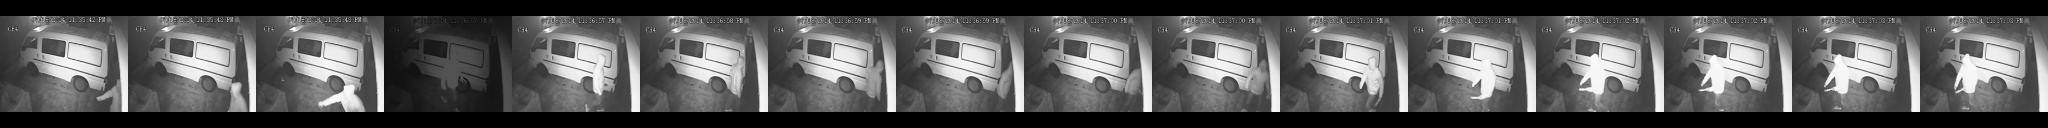

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow
# os.makedirs("normal/test/")
os.makedirs('normal/',exist_ok = True)

seq = 16
frame_num = 0

path = '/content/drive/MyDrive/Pro_data/Anomaly_Dataset/Anomaly_Videos/Anomaly-Videos-Part-1/Abuse/Abuse001_x264.mp4'
des = '/content/normal/'

cap = cv2.VideoCapture(path)

# Get the frames per second
fps = cap.get(cv2.CAP_PROP_FPS) 

# Get the total numer of frames in the video.
frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)
skip = 15


# print(frame_count)

# while frame_num + (seq * skip) <= frame_count:
count = 0
frame_number = frame_num
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # optional
success, image = cap.read()
img1 = cv2.resize(image, (128,128))
while count < seq-1:
  try:
      frame_number += skip
      cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number) # optional
      success, image = cap.read()
      image = cv2.resize(image, (128,128))
  except:
      print(path)
  # print(frame_num)
  # print(frame_count)
  img1 = np.append(img1,image,axis = 1)
  count += 1
  # frame_num += frame_number
  # k += 1
  
# cv2.imwrite(des + str(frame_number) +".jpg",img1)
cv2.imwrite( "image.jpg",img1)
frame_num = frame_number
cv2_imshow(img1)
img = img1

In [ ]:
from IPython.display import HTML
from base64 import b64encode

video_path = path
mp4 = open(video_path, "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""
<video width=400 controls>
      <source src="{data_url}" type="video/mp4">
</video>
""")

In [ ]:
img = cv2.imread("/content/image.jpg")
seq_img = list()
for i in range(16):
  img1 = img[:,128*i:128*(i+1),:].astype("uint8")
  img1 = torchvision.transforms.functional.to_tensor(img1)
  img1 = transforms.Normalize(mean,std)(img1)
  img1 = transforms.Resize((im_size,im_size))(img1)
  img1 = img1.to('cuda' if torch.cuda.is_available() else 'cpu')
  seq_img.append(img1)
seq_image = torch.stack(seq_img)
seq_image = seq_image.reshape(3,16,im_size,im_size)
seq_image = seq_image.reshape([1,3, 16, 128, 128])
# print(seq_image.shape)
# seq_image = seq_image.cuda()

from model import resnet50
model = resnet50(class_num=8).to('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('/content/drive/Shareddrives/One/c3d_11_0.01.h5',map_location=torch.device(device)))
model.eval()
model(seq_image)
pred = (model(seq_image)).argmax()
# tar.append(encoder[pred.item()])
print(encoder[pred.item()])

In [ ]:
tar = []
for i in range(len(id)):
    path = id[i][1]
    print(path)
    if path.endswith(".jpg"): 
      # print("ori",id[i][0])
      img = cv2.imread(path)
      seq_img = list()
      for i in range(16):
        img1 = img[:,128*i:128*(i+1),:].astype("uint8")
        img1 = torchvision.transforms.functional.to_tensor(img1)
        img1 = transforms.Normalize(mean,std)(img1)
        img1 = transforms.Resize((im_size,im_size))(img1)
        img1 = img1.to('cuda' if torch.cuda.is_available() else 'cpu')
        seq_img.append(img1)
      seq_image = torch.stack(seq_img)
      seq_image = seq_image.reshape(3,16,im_size,im_size)
      seq_image = seq_image.reshape([1,3, 16, 128, 128])
      # print(seq_image.shape)
      # seq_image = seq_image.cuda()

      from model import resnet50
      model = resnet50(class_num=8).to('cuda' if torch.cuda.is_available() else 'cpu')
      model.load_state_dict(torch.load('/content/drive/Shareddrives/One/c3d_11_0.01.h5',map_location=torch.device(device)))
      model.eval()
      model(seq_image)
      pred = (model(seq_image)).argmax()
      tar.append(encoder[pred.item()])
      print(encoder[pred.item()])

Explosion
/content/drive/MyDrive/IFrames/crime16/Arson/Arson021_x2640.jpg
Abuse
/content/drive/MyDrive/IFrames/crime16/Arrest/Arrest028_x2640.jpg
Burglary
